# TGP 2 Kelompok x
- xxx (xxx)
- xxx (xxx)
- xxx (xxx)
- xxx (xxx)

## Setup

In [21]:
# Setup (import libraries and dataset)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate as tb
import random
import json

from warnings import simplefilter
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf

from sklearn.feature_selection import RFE, RFECV, SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, RepeatedKFold, RepeatedStratifiedKFold, ShuffleSplit, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, classification_report, roc_auc_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning

DATASET_PATH = './dataset/Data utk TGP #1.csv'
pd.set_option('display.max_columns', None)

# somehow the dataset attributes are seperated with semicolons instead of commas
DATASET = pd.read_csv(DATASET_PATH, delimiter=';')

## Data PreProcessing

References:
- https://medium.com/analytics-vidhya/removing-outliers-understanding-how-and-what-behind-the-magic-18a78ab480ff
- https://www.kaggle.com/code/faressayah/outlier-detection-using-pdf-and-z-score
- https://medium.com/pythoneers/brushing-out-outliers-from-your-dataset-the-z-score-method-f46dd58e5091
- https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/
- https://www.kaggle.com/code/rpsuraj/outlier-detection-techniques-simplified
- https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python

### Basic Info

In [2]:
DATASET.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [3]:
# list of categorical attributes and its unique values
for key in DATASET:
    if DATASET[key].dtype != 'int64':
        print(f'{key}: {DATASET[key].unique()}')

print()
DATASET.info()

job: ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
marital: ['married' 'single' 'divorced']
education: ['tertiary' 'secondary' 'unknown' 'primary']
default: ['no' 'yes']
housing: ['yes' 'no']
loan: ['no' 'yes']
contact: ['unknown' 'cellular' 'telephone']
month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
poutcome: ['unknown' 'failure' 'other' 'success']
subscribe: ['no' 'yes']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non

### Missing, Null, Duplicated Values

In [2]:
# duplicated rows/objects
dups = DATASET.duplicated().sum()
print(f"Sum of duplicate objects: {dups}")

Sum of duplicate objects: 0


In [3]:
# null values
print(f'Null/NaN Values: \n{DATASET.isnull().sum()}', '\n')

# missing/unknown values
def count_unknown_values(df: pd.DataFrame, columns_with_unknowns=['job', 'education', 'contact', 'poutcome']):
  data = []

  for key in df:
    if key not in columns_with_unknowns:
      continue

    unknown_counts = 0
    try:
      unknown_counts = df[key].value_counts()['unknown']
    except:
      unknown_counts = 0

    unknown_percentile = (unknown_counts / df.shape[0]) * 100
    data.append([key, unknown_counts, f'{unknown_percentile:.2f}%'])

  table = tb.tabulate(data, headers=['Columns', 'Unknown Count', 'Percentage'])
  print(table)

count_unknown_values(DATASET)

Null/NaN Values: 
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
subscribe    0
dtype: int64 

Columns      Unknown Count  Percentage
---------  ---------------  ------------
job                    288  0.64%
education             1857  4.11%
contact              13020  28.80%
poutcome             36959  81.75%


In [4]:
DATASET_VER2 = DATASET.copy()

# Removes the poutcome attribute as it has too many missing values and deemed unvalid
DATASET_VER2 = DATASET_VER2.drop(columns=['poutcome'])

# Fill in the missing values with their respective modes for the columns that have relatively small amounts
DATASET_VER2['contact'] = DATASET_VER2['contact'].replace('unknown', DATASET_VER2['contact'].mode()[0])

# since 'job' and 'education' are below 5% we decide not to remove or fill the missing values
count_unknown_values(DATASET_VER2)

DATASET_VER2.tail(10)

Columns      Unknown Count  Percentage
---------  ---------------  ------------
job                    288  0.64%
education             1857  4.11%
contact                  0  0.00%


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,subscribe
45201,53,management,married,tertiary,no,583,no,no,cellular,17,nov,226,1,184,4,yes
45202,34,admin.,single,secondary,no,557,no,no,cellular,17,nov,224,1,-1,0,yes
45203,23,student,single,tertiary,no,113,no,no,cellular,17,nov,266,1,-1,0,yes
45204,73,retired,married,secondary,no,2850,no,no,cellular,17,nov,300,1,40,8,yes
45205,25,technician,single,secondary,no,505,no,yes,cellular,17,nov,386,2,-1,0,yes
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,no
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,no


### Outliers

#### Distribution
to determine the method to use for removing outliers

according to this [blog](https://medium.com/analytics-vidhya/removing-outliers-understanding-how-and-what-behind-the-magic-18a78ab480ff), if the distribution is skewed either to the left or the right, it is recommended to use IQR method.

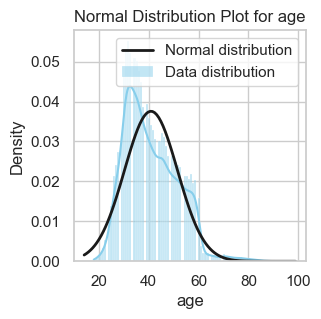

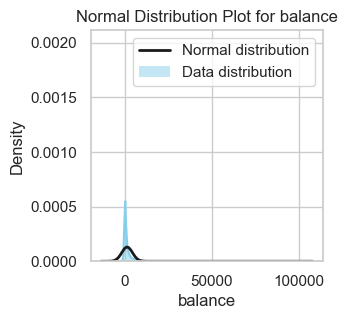

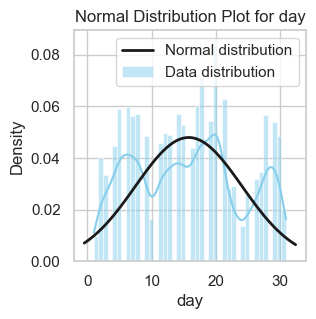

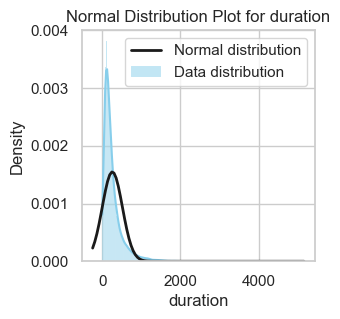

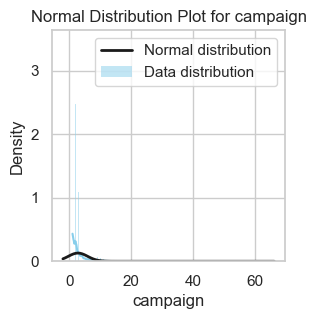

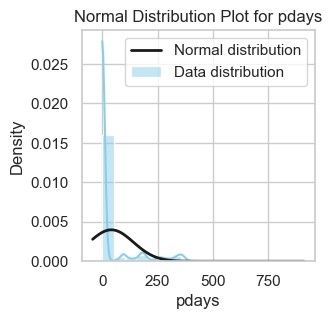

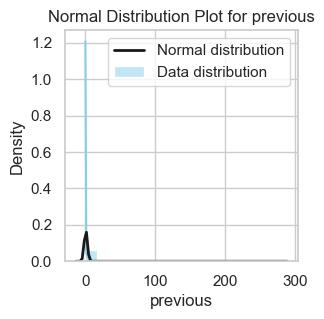

In [7]:
from scipy.stats import norm

def plot_normal_distribution(data, column_name):
    sns.set(style="whitegrid")
    plt.figure(figsize=(3, 3))
    sns.histplot(data[column_name], kde=True, color="skyblue", label="Data distribution", stat="density")
    mu, sigma = np.mean(data[column_name]), np.std(data[column_name])
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, sigma)  # Use norm.pdf for the normal distribution
    plt.plot(x, p, 'k', linewidth=2, label="Normal distribution")
    plt.title(f"Normal Distribution Plot for {column_name}")
    plt.xlabel(column_name)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

for column in DATASET_VER2.select_dtypes(include=np.number).columns:
    plot_normal_distribution(DATASET_VER2, column)

#### IQR

In [8]:
def check_outlier_exist(df: pd.DataFrame, col, upper, lower) -> bool:
  return True if df[(df[col] > upper) | (df[col] < lower)].any(axis=None) else False

def determine_IQR_threshold(df: pd.DataFrame, col, th1=0.25, th3=0.75) -> tuple[int, int]:
  q1 = df[col].quantile(th1)
  q3 = df[col].quantile(th3)
  IQR = q3 - q1
  upper = q3 + (1.5 * IQR)
  lower = q1 - (1.5 * IQR)
  return lower, upper

def remove_outliers_IQR(df: pd.DataFrame, columns, th1=0.25, th3=0.75, replace=False) -> pd.DataFrame:
  df = df.copy()
  data = []

  # iterate for every attributes
  for col in columns:
    # skip if not numerical
    if df[col].dtype != 'int64':
      continue

    # get lower and upper limites
    lower, upper = determine_IQR_threshold(df, col, th1, th3)

    outliers_exist = check_outlier_exist(df, col, upper, lower)
    outliers_count = df[(df[col] > upper) | (df[col] < lower)][col].count()
    outliers_percentage = f'{(outliers_count / df.shape[0]) * 100:.2f}%'

    # remove the outliers
    if outliers_exist and replace:
      df = df.drop(df[(df[col] > upper) | (df[col] < lower)].index)

    # check if the outlier still exist
    outliers_status = check_outlier_exist(df, col, upper, lower)
    data.append([col, outliers_exist, outliers_status, outliers_count, outliers_percentage, lower, upper])

  # print information to debug
  table = tb.tabulate(data, headers=['Column', 'Outliers (Previous)', 'Outliers (Current)', 'Count', 'Percentage', 'Lower Limit', 'Upper Limit'])
  print(table, '\n')

  return df

DATASET_VER3 = remove_outliers_IQR(DATASET_VER2, DATASET_VER2.columns, 0.25, 0.75, replace=True)

DATASET_VER3.head()

Column    Outliers (Previous)    Outliers (Current)      Count  Percentage      Lower Limit    Upper Limit
--------  ---------------------  --------------------  -------  ------------  -------------  -------------
age       True                   False                     487  1.08%                  10.5           70.5
balance   True                   False                    4696  10.50%              -1934.5         3413.5
day       False                  False                       0  0.00%                 -11.5           40.5
duration  True                   False                    2878  7.19%                -217.5          634.5
campaign  True                   False                    2587  6.96%                  -2              6
pdays     True                   False                    6494  18.79%                 -1             -1
previous  False                  False                       0  0.00%                   0              0 



,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,subscribe
0,58,management,married,tertiary,no,2143,yes,no,cellular,5,may,261,1,-1,0,no
1,44,technician,single,secondary,no,29,yes,no,cellular,5,may,151,1,-1,0,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,cellular,5,may,76,1,-1,0,no
3,47,blue-collar,married,unknown,no,1506,yes,no,cellular,5,may,92,1,-1,0,no
4,33,unknown,single,unknown,no,1,no,no,cellular,5,may,198,1,-1,0,no


#### Standard Deviation

In [9]:
def determine_STD_threshold(df: pd.DataFrame, col) -> tuple[int, int]:
  upper = df[col].mean() + 3 * df[col].std()
  lower = df[col].mean() - 3 * df[col].std()
  return lower, upper

def remove_outliers_STD(df: pd.DataFrame, columns, replace=False) -> pd.DataFrame:
  df = df.copy()
  data = []

  # iterate for every attributes
  for col in columns:

    # skip if not numerical
    if df[col].dtype != 'int64':
      continue

    # get lower and upper limites
    lower, upper = determine_STD_threshold(df, col)

    outliers_exist = check_outlier_exist(df, col, upper, lower)
    outliers_count = df[(df[col] > upper) | (df[col] < lower)][col].count()
    outliers_percentage = f'{(outliers_count / df.shape[0]) * 100:.2f}%'

    # remove the outliers
    if outliers_exist and replace:
      df = df.drop(df[(df[col] > upper) | (df[col] < lower)].index)

    # check if the outlier still exist
    outliers_status = check_outlier_exist(df, col, upper, lower)
    data.append([col, outliers_exist, outliers_status, outliers_count, outliers_percentage, lower, upper])

  # print information to debug
  table = tb.tabulate(data, headers=['Column', 'Outliers (Previous)', 'Outliers (Current)', 'Count', 'Percentage', 'Lower Limit', 'Upper Limit'])
  print(table, '\n')

  return df

DATASET_TMP = remove_outliers_STD(DATASET_VER2, DATASET_VER2.columns, replace=True)
DATASET_TMP.tail(10)

Column    Outliers (Previous)    Outliers (Current)      Count  Percentage      Lower Limit    Upper Limit
--------  ---------------------  --------------------  -------  ------------  -------------  -------------
age       True                   False                     381  0.84%               9.07992       72.7925
balance   True                   False                     763  1.70%           -7613.51       10312.1
day       False                  False                       0  0.00%              -9.18303       40.8019
duration  True                   False                     940  2.13%            -514.672       1029.71
campaign  True                   False                     816  1.89%              -6.5609        12.1024
pdays     True                   False                    1495  3.53%            -262.856        344.902
previous  True                   False                     476  1.17%              -6.19936        7.21274 



,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,subscribe
45196,25,student,single,secondary,no,358,no,no,cellular,16,nov,330,1,-1,0,yes
45197,36,management,single,secondary,no,1511,yes,no,cellular,16,nov,270,1,-1,0,yes
45198,37,management,married,tertiary,no,1428,no,no,cellular,16,nov,333,2,-1,0,no
45201,53,management,married,tertiary,no,583,no,no,cellular,17,nov,226,1,184,4,yes
45202,34,admin.,single,secondary,no,557,no,no,cellular,17,nov,224,1,-1,0,yes
45203,23,student,single,tertiary,no,113,no,no,cellular,17,nov,266,1,-1,0,yes
45205,25,technician,single,secondary,no,505,no,yes,cellular,17,nov,386,2,-1,0,yes
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,no


#### Z-Score

In [5]:
def out_zscore(df: pd.DataFrame, col, threshold=3):
  outliers = []
  zscores = []

  mean = np.mean(df[col])
  std = np.std(df[col])

  for idx in df[col]:
    z_score = (idx - mean) / std
    zscores.append(z_score)

    if np.abs(z_score) > threshold:
      outliers.append(idx)

  return outliers, zscores

def remove_outliers_ZScore(df: pd.DataFrame, columns, threshold=3, replace=False) -> pd.DataFrame:
  df = df.copy()
  data = []

  # iterate for every attributes
  for col in columns:

    # skip if not numerical
    if df[col].dtype != 'int64':
      continue

    outliers, _ = out_zscore(df, col, threshold)
    outliers_exist = len(outliers) > 0

    outliers_percentage = '0.00%'
    if outliers_exist:
      outliers_percentage = f'{(len(outliers) / df.shape[0]) * 100:.2f}%'

      # remove the outliers
      if replace:
        df = df[(df[col] < threshold) | (df[col] > -(threshold))]

    # check if the outlier still exist
    tmp, _ = out_zscore(df, col, threshold)
    outliers_status = len(tmp) > 0
    data.append([col, outliers_exist, outliers_status, threshold, len(outliers), outliers_percentage])


  # print information to debug
  table = tb.tabulate(data, headers=['Column', 'Outliers (Previous)', 'Outliers (Current)', 'Threshold', 'Count', 'Percentage'])
  print(table, '\n')

  return df

DATASET_TMP = remove_outliers_ZScore(DATASET_VER2, DATASET_VER2.columns, replace=False)
DATASET_TMP.tail(10)

Column    Outliers (Previous)    Outliers (Current)      Threshold    Count  Percentage
--------  ---------------------  --------------------  -----------  -------  ------------
age       True                   True                            3      381  0.84%
balance   True                   True                            3      745  1.65%
day       False                  False                           3        0  0.00%
duration  True                   True                            3      963  2.13%
campaign  True                   True                            3      840  1.86%
pdays     True                   True                            3     1723  3.81%
previous  True                   True                            3      582  1.29% 



,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,subscribe
45201,53,management,married,tertiary,no,583,no,no,cellular,17,nov,226,1,184,4,yes
45202,34,admin.,single,secondary,no,557,no,no,cellular,17,nov,224,1,-1,0,yes
45203,23,student,single,tertiary,no,113,no,no,cellular,17,nov,266,1,-1,0,yes
45204,73,retired,married,secondary,no,2850,no,no,cellular,17,nov,300,1,40,8,yes
45205,25,technician,single,secondary,no,505,no,yes,cellular,17,nov,386,2,-1,0,yes
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,no
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,no


### Feature Encoding

In [6]:
columns_to_one_hot = ['job', 'education', 'marital', 'contact']
columns_to_label_encode = ['default', 'housing', 'loan', 'subscribe']
columns_to_ordinal_encode = [ 'month']

DATASET_ENCODED = DATASET_TMP.copy()
one_hot_encoded = {}

print(f"[*] One-hot encoding for {columns_to_one_hot}")
for column in columns_to_one_hot:
    one_hot_encoded[column] = pd.get_dummies(DATASET_ENCODED[column])
for column in columns_to_one_hot:
    DATASET_ENCODED = pd.concat([DATASET_ENCODED, one_hot_encoded[column]], axis=1)
DATASET_ENCODED.drop(columns=columns_to_one_hot, inplace=True)

for column in DATASET_ENCODED.columns:
    DATASET_ENCODED.replace({True: 1, False: 0}, inplace=True)

print(f"[*] Label encoding for {columns_to_label_encode}")
DATASET_ENCODED.replace({'yes': 1, 'no': 0}, inplace=True)

print(f'[*] Ordinal encoding for {columns_to_ordinal_encode}')
DATASET_ENCODED.replace({
    'month' : {
        'jan': 1,
        'feb': 2,
        'mar': 3,
        'apr': 4,
        'may': 5,
        'jun': 6,
        'jul': 7,
        'aug': 8,
        'sep': 9,
        'oct': 10,
        'nov': 11,
        'dec': 12
        }
    }, inplace=True)

DATASET_ENCODED.head()

[*] One-hot encoding for ['job', 'education', 'marital', 'contact']
[*] Label encoding for ['default', 'housing', 'loan', 'subscribe']
[*] Ordinal encoding for ['month']


,age,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,subscribe,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown,primary,secondary,tertiary,unknown,divorced,married,single,cellular,telephone
0,58,0,2143,1,0,5,5,261,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0
1,44,0,29,1,0,5,5,151,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0
2,33,0,2,1,1,5,5,76,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
3,47,0,1506,1,0,5,5,92,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
4,33,0,1,0,0,5,5,198,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0


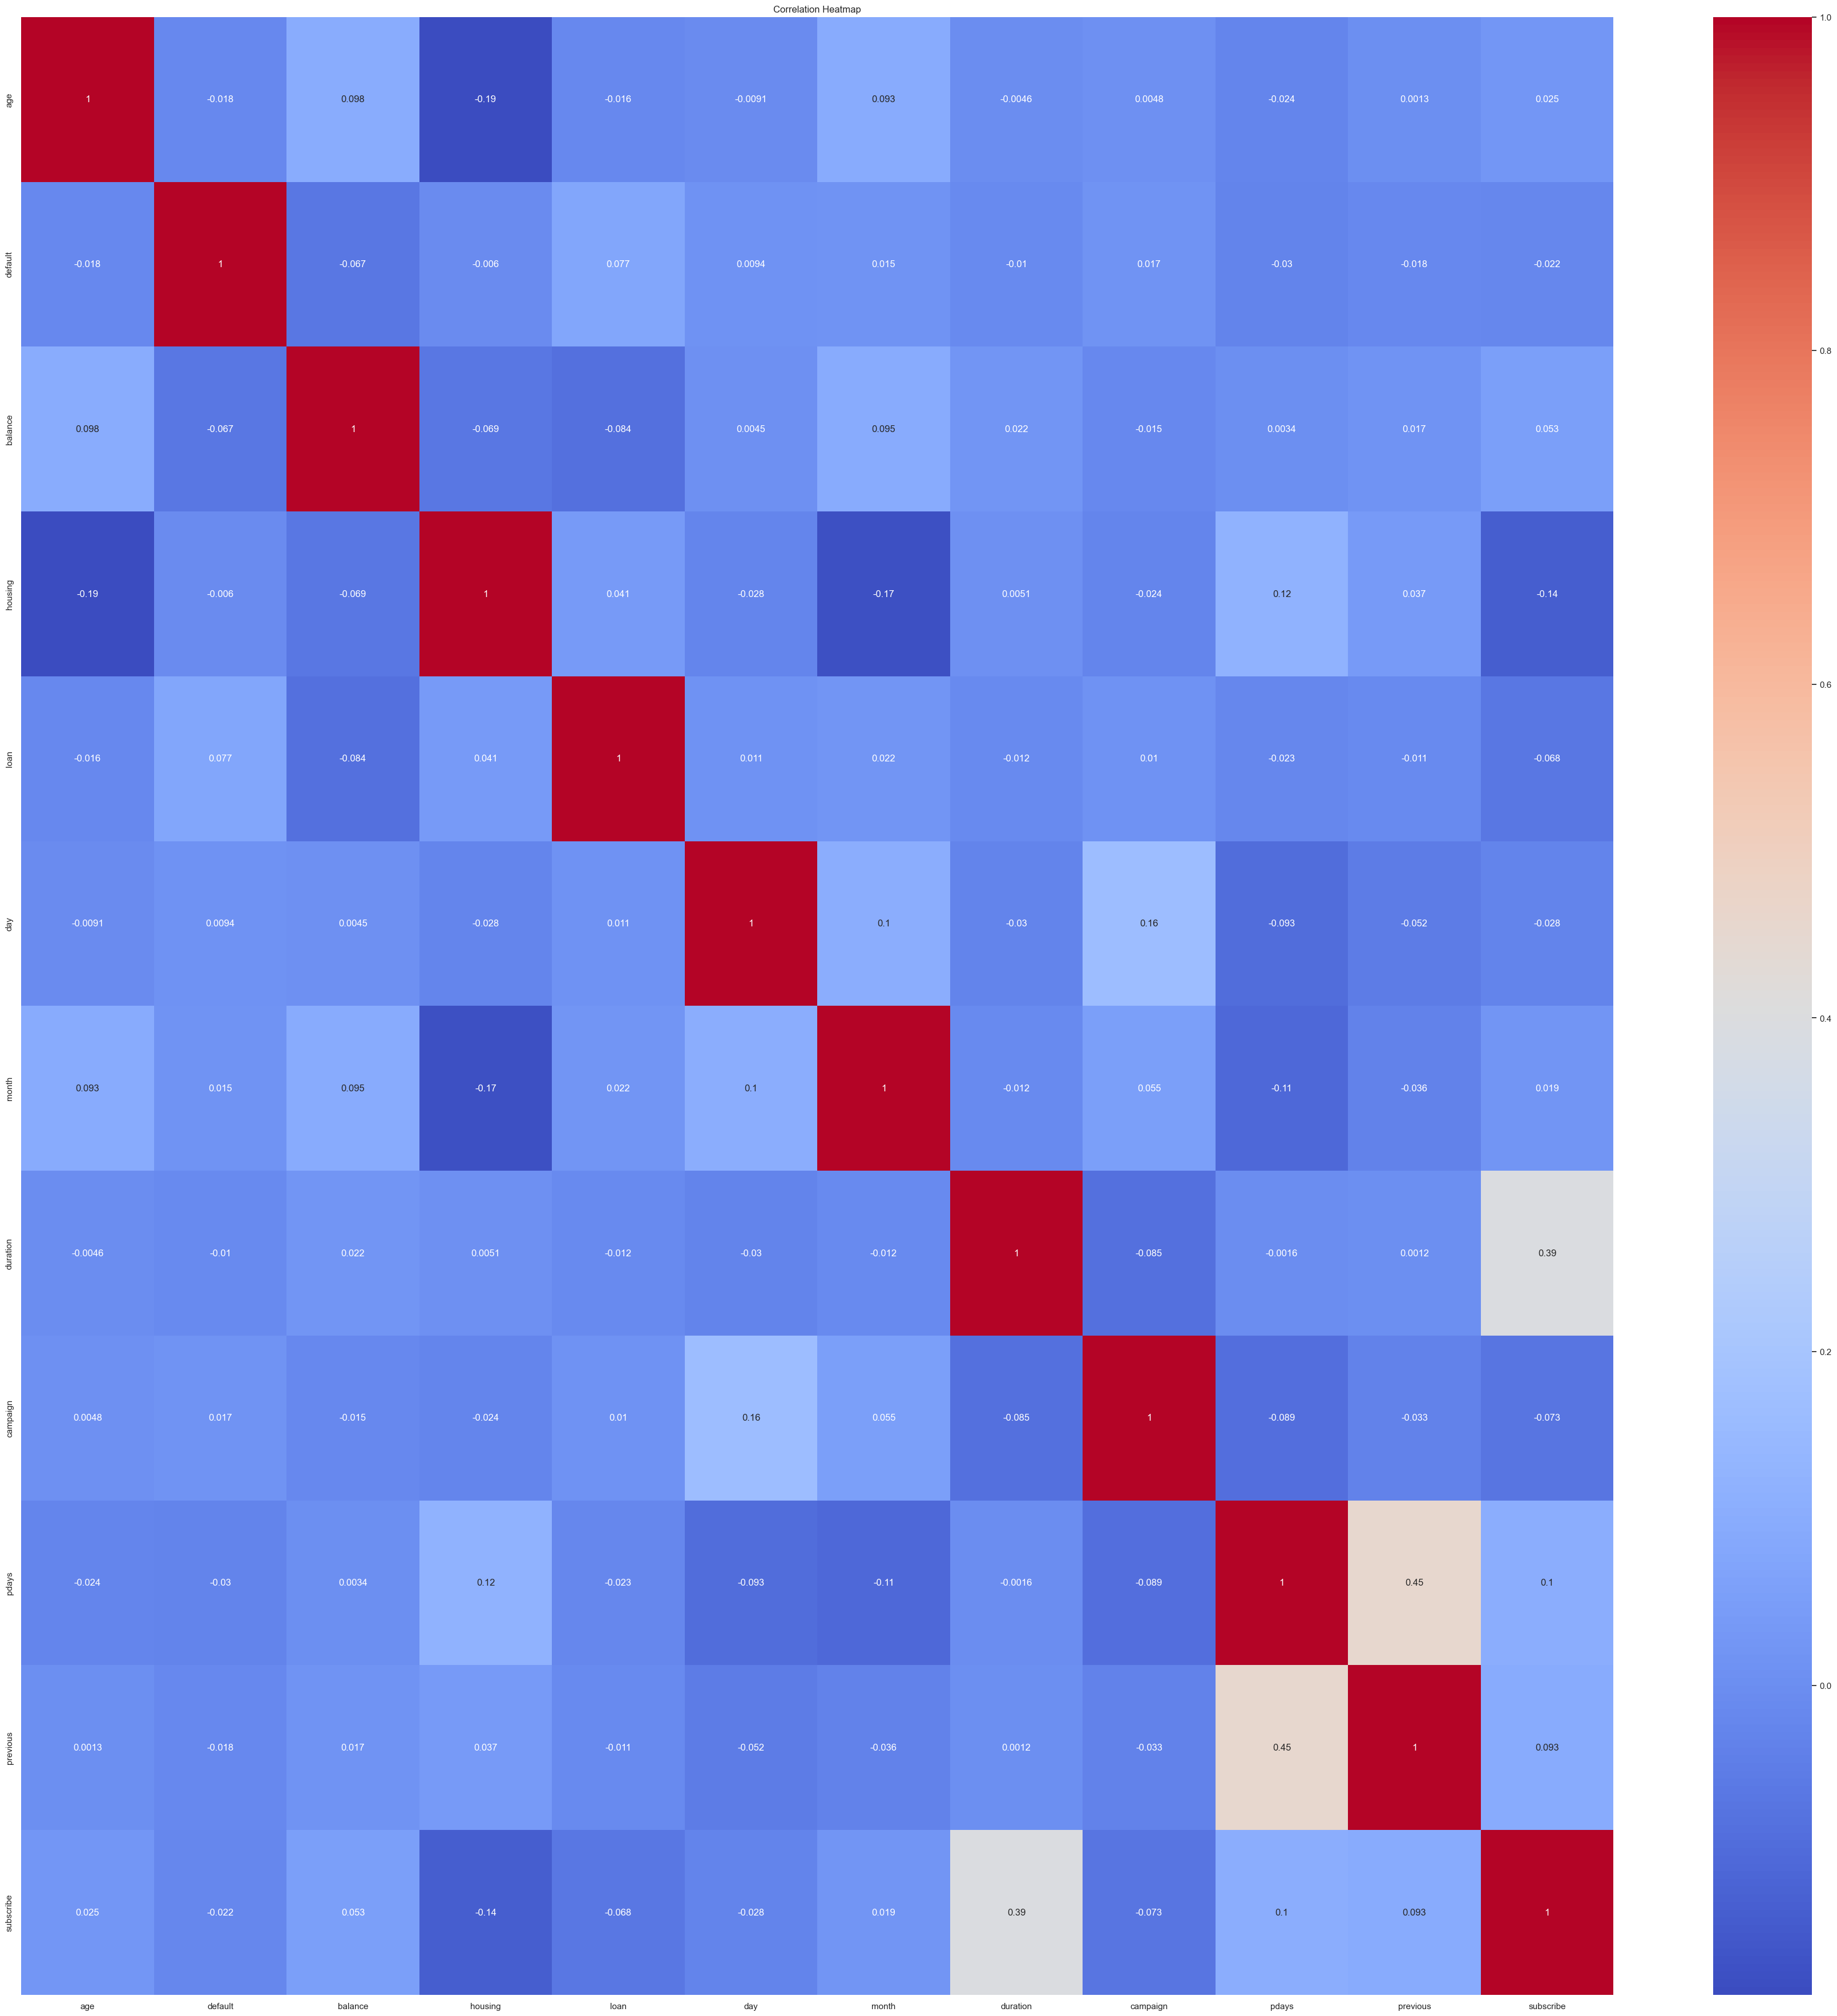

In [12]:
numeric_features = DATASET_ENCODED.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numeric_features.corr()

plt.figure(figsize=(45, 45))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

## Data preparation

### Feature Selection

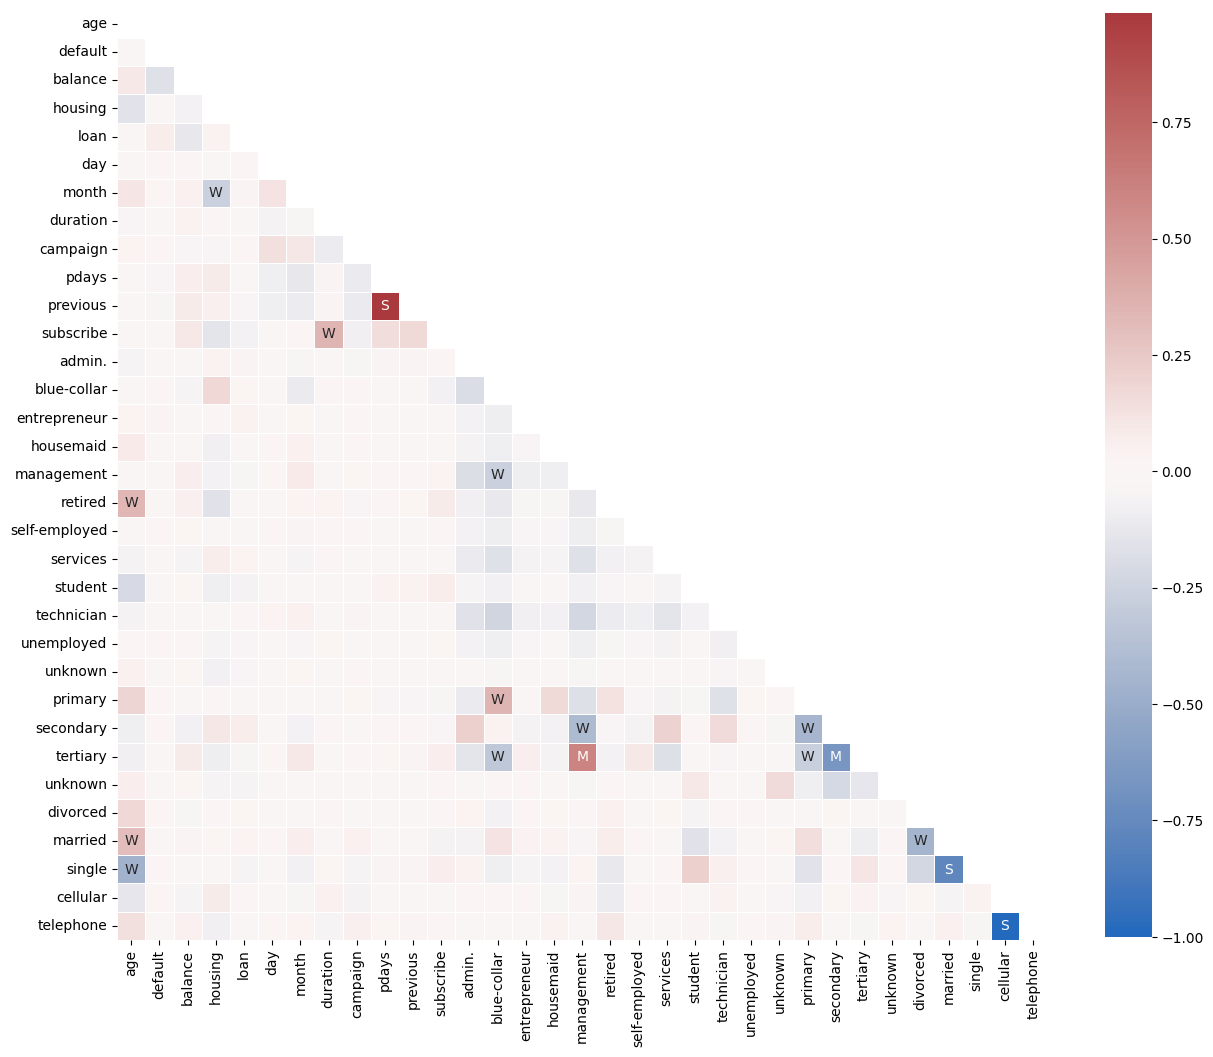

In [9]:
correlation = DATASET_ENCODED.corr('spearman')
plt.figure(figsize=(15, 15))
sns.heatmap(correlation,
            annot = np.where(np.abs(correlation)>0.75,'S',
                      np.where(np.abs(correlation)>0.5,'M',
                           np.where(np.abs(correlation)>0.25,'W',''))),
            mask=np.triu(np.ones_like(correlation, dtype=bool)),
            square=True,
            center=0,fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8}
            )
plt.show()

In [10]:
correlation[['previous','single', 'telephone']]

,previous,single,telephone
age,-0.011900,-0.459138,0.134618
default,-0.039279,0.003115,-0.017208
balance,0.079536,-0.000554,0.048190
housing,0.062087,-0.020475,-0.080822
loan,-0.030700,-0.051716,-0.013183
day,-0.087780,-0.008258,0.021953
month,-0.105835,-0.073597,0.039346
duration,0.031175,0.022844,-0.051922
campaign,-0.108448,-0.046899,0.059964
pdays,0.985645,0.031112,0.022444


In [11]:
correlation.sort_values('subscribe', ascending=False, key=abs)['subscribe']

subscribe        1.000000
duration         0.342469
previous         0.169124
pdays            0.154055
housing         -0.139173
balance          0.100295
campaign        -0.084054
retired          0.079245
student          0.076897
blue-collar     -0.072083
loan            -0.068185
tertiary         0.066448
single           0.063526
married         -0.060260
primary         -0.040393
secondary       -0.036388
management       0.032919
day             -0.029548
services        -0.027864
default         -0.022419
unemployed       0.020390
entrepreneur    -0.019662
housemaid       -0.015195
cellular        -0.014042
telephone        0.014042
month            0.012410
unknown          0.012053
technician      -0.008970
age             -0.008750
admin.           0.005637
divorced         0.002772
self-employed    0.000855
unknown          0.000267
Name: subscribe, dtype: float64

In [7]:
DATASET_FEAT_SELECTED = DATASET_ENCODED.drop(['pdays', 'married', 'telephone'], axis=1)
DATASET_FEAT_SELECTED.head()

,age,default,balance,housing,loan,day,month,duration,campaign,previous,subscribe,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown,primary,secondary,tertiary,unknown,divorced,single,cellular
0,58,0,2143,1,0,5,5,261,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,44,0,29,1,0,5,5,151,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1
2,33,0,2,1,1,5,5,76,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,47,0,1506,1,0,5,5,92,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
4,33,0,1,0,0,5,5,198,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1


### Data Balancing

In [8]:
print(f"[*] Before Balancing: \n{DATASET_ENCODED['subscribe'].value_counts()}")

x = DATASET_ENCODED.drop('subscribe', axis=1)
y = DATASET_ENCODED['subscribe']

rand_seed = random.randint(0, 100)
balancer = RandomOverSampler(random_state=rand_seed)
x_balanced, y_balanced = balancer.fit_resample(x, y)
print(f"[*] After Balancing: \n{y_balanced.value_counts()}")

[*] Before Balancing: 
0    39922
1     5289
Name: subscribe, dtype: int64
[*] After Balancing: 
0    39922
1    39922
Name: subscribe, dtype: int64


## Model Klasifikasi

### 10-Cross Validation

In [29]:
# K-fold Cross Validation

def default_encoder(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        raise TypeError(f'Object of type {obj.__class__.__name__} is not JSON serializable')

def kfoldcross(clf, pool, main_seed, iter):
    x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.3, random_state=main_seed, stratify=y_balanced)

    fold_seed = random.randint(1, 200)
    pool[f"iter-{iter}"]= {
        "seed": fold_seed,
        "folds": []
    }

    # print(f"[*] fold seed = {fold_seed}")
    strat_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=fold_seed)

    train_set_kfold = []
    test_set_kfold = []

    for i, (train_index, test_index) in enumerate(strat_kfold.split(x_train, y_train)):
        train_set_kfold.append(train_index)
        test_set_kfold.append(test_index)

    feature_to_scale = ['age', 'balance', 'duration', 'campaign', 'previous']
    scaler = StandardScaler()

    for col in feature_to_scale:
        x_train[col] = scaler.fit_transform(x_train[[col]])
        x_test[col] = scaler.transform(x_test[[col]])

    knn_params = {
        'n_neighbors': 3,
        'weights': 'uniform',
        'algorithm': 'auto',
        'leaf_size': 30,
        'p': 2
    }

    # print(f'[*] KFold - Iterasi {iter} (random_state={fold_seed})\n')
    for i, (train_index, test_index) in enumerate(zip(train_set_kfold, test_set_kfold)):
        x_train_fold = x_train.iloc[train_index]
        x_test_fold = x_train.iloc[test_index]
        y_train_fold = y_train.iloc[train_index]
        y_test_fold = y_train.iloc[test_index]

        clf.fit(x_train_fold, y_train_fold)
        y_pred_fold = clf.predict(x_test_fold)
        y_pred_proba_fold = clf.predict_proba(x_test_fold)

        # print(f'Fold {i}')
        auc_roc = roc_auc_score(y_test_fold, y_pred_proba_fold[:, 1])
        # print(f'AUC-ROC for Fold {i}: {auc_roc:.4f}')

        conf_matrix = confusion_matrix(y_test_fold, y_pred_fold)
        tn, fp, fn, tp = conf_matrix.ravel()
        # print(f'True Negative (TN): {tn}')
        # print(f'False Positive (FP): {fp}')
        # print(f'False Negative (FN): {fn}')
        # print(f'True Positive (TP): {tp}')

        # print(f'Accuracy: {accuracy_score(y_test_fold, y_pred_fold)}')
        # print('Classification report:\n', classification_report(y_test_fold, y_pred_fold))
        fold_accuracy = accuracy_score(y_test_fold, y_pred_fold)

        pool[f"iter-{iter}"]["folds"].append({
            f"fold-{i}": {
                "accuracy": fold_accuracy,
                "auc_roc": auc_roc,
                "conf_matrix": {
                    "tn": tn,
                    "fp": fp,
                    "fn": fn,
                    "tp": tp,
                }
            }
        })

    folds = [i for i in pool[f'iter-{iter}']["folds"]]
    accuracies = [list(fold.values())[0]['accuracy'] for fold in folds]
    aucs_rocs = [list(fold.values())[0]['auc_roc'] for fold in folds]

    pool[f'iter-{iter}']["average auc"] = sum(aucs_rocs) / len(pool[f"iter-{iter}"]["folds"])
    pool[f'iter-{iter}']["average accuracy"] = sum(accuracies) / len(pool[f"iter-{iter}"]["folds"])
    pool[f'iter-{iter}']["std"] = np.std(accuracies)

In [24]:
dt_params = {
    'random_state': 147
}
knn_params = {
    'n_neighbors': 3,
    'metric': 'euclidean'
}
svm_params = {
    'C': 10,
    'kernel': 'rbf',
    'probability': True
}
logistic_params = {
    'solver': 'lbfgs',
    'random_state': 61,
    'max_iter': 1000
}
rf_params = {
    'max_features': 'log2'
}

decision_tree = DecisionTreeClassifier(**dt_params)
knn = KNeighborsClassifier(**knn_params)
naive_bayes = GaussianNB()
svm = SVC(**svm_params)
logistic_regression = LogisticRegression(**logistic_params)
random_forest = RandomForestClassifier(**rf_params)

models = {
    'k-NN': knn,
    'Decision Tree': decision_tree,
    'Naïve Bayes': naive_bayes,
    'Logistic Regression': logistic_regression,
    'Random Forest': random_forest
    'SVM': svm,
    'BPNN': bpnn,
}

results = {}
main_seed = random.randint(1, 200)
print(f'[*] split seed = {main_seed}')

for name, clf in models.items():
    pool = {}
    main_seed = random.randint(1, 200)
    print(f'[*] {name} [random_state={main_seed}]')
    for i in range(3):
        print(f'[*] iter-{i+1}')
        kfoldcross(clf, pool, i, main_seed)
    print(json.dumps(pool, indent=4, default=default_encoder))



[*] split seed = 70
[*] k-NN [random_state=30]
[*] iter-1
[*] iter-2
[*] iter-3
{
    "iter-30": {
        "seed": 102,
        "folds": [
            {
                "fold-0": {
                    "accuracy": 0.9234210055466094,
                    "auc_roc": 0.9543695729284449,
                    "conf_matrix": {
                        "tn": 2406,
                        "fp": 389,
                        "fn": 39,
                        "tp": 2755
                    }
                }
            },
            {
                "fold-1": {
                    "accuracy": 0.9200214707461084,
                    "auc_roc": 0.9523556739909056,
                    "conf_matrix": {
                        "tn": 2390,
                        "fp": 405,
                        "fn": 42,
                        "tp": 2752
                    }
                }
            },
            {
                "fold-2": {
                    "accuracy": 0.9151905528717122,
             

In [ ]:
# Special Case for BPNN (custom)

def default_encoder(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        raise TypeError(f'Object of type {obj._class.name_} is not JSON serializable')

def kfoldcross(iter, pool):
    # Train-test split dengan stratifikasi
    x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.3, random_state=main_seed, stratify=y_balanced)

    # Random seed untuk fold
    fold_seed = random.randint(1, 200)
    pool[f"iter-{iter}"] = {
        "seed": fold_seed,
        "folds": []
    }

    print(f"[*] fold seed = {fold_seed}")
    strat_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=fold_seed)

    train_set_kfold = []
    test_set_kfold = []

    for i, (train_index, test_index) in enumerate(strat_kfold.split(x_train, y_train)):
        train_set_kfold.append(train_index)
        test_set_kfold.append(test_index)

    # Normalisasi data
    feature_to_scale = ['age', 'balance', 'duration', 'campaign', 'previous']
    scaler = StandardScaler()

    x_train_copy = x_train.copy()  # Salin data untuk menghindari modifikasi
    x_test_copy = x_test.copy()  # Salin data untuk menghindari modifikasi

    for col in feature_to_scale:
        x_train_copy[col] = scaler.fit_transform(x_train_copy[[col]])
        x_test_copy[col] = scaler.transform(x_test_copy[[col]])

    # Model Neural Network
    nn = tf.keras.models.Sequential([
        tf.keras.layers.Dense(16, activation='relu', input_dim=x_train_copy.shape[1]),  # Lapisan tersembunyi pertama
        tf.keras.layers.Dropout(0.2),  # Dropout untuk mencegah overfitting
        tf.keras.layers.Dense(8, activation='relu'),  # Lapisan tersembunyi kedua
        tf.keras.layers.Dropout(0.2),  # Dropout lagi
        tf.keras.layers.Dense(1, activation='sigmoid')  # Lapisan keluaran untuk klasifikasi biner
    ])

    nn.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision'])

    # print(f'[*] KFold - Iterasi {iter} (random_state={fold_seed})\n')

    for i, (train_index, test_index) in enumerate(zip(train_set_kfold, test_set_kfold)):
        x_train_fold = x_train_copy.iloc[train_index]
        x_test_fold = x_train_copy.iloc[test_index]
        y_train_fold = y_train.iloc[train_index]
        y_test_fold = y_train.iloc[test_index]

        nn.fit(x_train_fold, y_train_fold, epochs=10, batch_size=16, verbose=0)

        # Prediksi probabilitas
        y_pred_proba_fold = nn.predict(x_test_fold)

        # Konversi ke prediksi kelas biner
        y_pred_fold_classes = (y_pred_proba_fold >= 0.5).astype(int)

        # AUC-ROC dengan probabilitas
        auc_roc = roc_auc_score(y_test_fold, y_pred_proba_fold)
        # print(f'AUC-ROC for Fold {i}: {auc_roc:.4f}')

        # Confusion matrix dan metrik lainnya menggunakan prediksi biner
        conf_matrix = confusion_matrix(y_test_fold, y_pred_fold_classes)
        tn, fp, fn, tp = conf_matrix.ravel()
        # print(f'True Negative (TN): {tn}')
        # print(f'False Positive (FP): {fp}')
        # print(f'False Negative (FN): {fn}')
        # print(f'True Positive (TP): {tp}')

        # print('Classification report:\n', classification_report(y_test_fold, y_pred_fold_classes))
        fold_accuracy = accuracy_score(y_test_fold, y_pred_fold_classes)

        pool[f"iter-{iter}"]["folds"].append({
            f"fold-{i}": {
                "accuracy": fold_accuracy,
                "auc_roc": auc_roc,
                "conf_matrix": {
                    "tn": tn,
                    "fp": fp,
                    "fn": fn,
                    "tp": tp,
                },
            },
        })

    folds = [fold for fold in pool[f'iter-{iter}']["folds"]]
    accuracies = [list(fold.values())[0]['accuracy'] for fold in folds]
    aucs_rocs = [list(fold.values())[0]['auc_roc'] for fold in folds]

    pool[f'iter-{iter}']["average auc"] = sum(aucs_rocs) / len(pool[f"iter-{iter}"]["folds"])
    pool[f'iter-{iter}']["average accuracy"] = sum(accuracies) / len(pool[f"iter-{iter}"]["folds"])
    pool[f'iter-{iter}']["std"] = np.std(accuracies)

# Ulangi proses 3 kali
for i in range(3):
    main_seed = random.randint(1, 200)
    print(f'[*] split seed = {main_seed}')
    pool = {}
    kfoldcross(i, pool)

# Output hasil
print(json.dumps(pool, indent=4, default=default_encoder))

### Feature Reduction

In [27]:
# SelectKBest
def select_k_best():
    x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.3, random_state=102, stratify=y_balanced)

    scaler = MinMaxScaler()
    x_train_scaled = scaler.fit_transform(x_train)

    X_10_best = SelectKBest(chi2, k=10).fit(x_train_scaled, y_train)
    mask = X_10_best.get_support()

    k_best_features = []
    for bool, feature in zip(mask, x_train.columns):
        if bool:
            k_best_features.append(feature)
    return k_best_features

# RFECV
simplefilter("ignore", category=ConvergenceWarning)
def cv_selector(clf):
    x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.3, random_state=102, stratify=y_balanced)
    selector = RFECV(clf, cv=5, step=1,scoring='accuracy')
    selector = selector.fit(x_train, y_train)
    rfecv_mask = selector.get_support()

    rfecv_features = [] 
    for bool, feature in zip(rfecv_mask, x_train.columns):
        if bool:
            rfecv_features.append(feature)

    feature_importance = sorted(zip(selector.ranking_, x_train.columns))
    selected_features = [feature[1] for feature in feature_importance][:10]
    return selected_features

# [*] k-NN => selected features: ['housing', 'loan', 'duration', 'pdays', 'blue-collar', 'retired', 'student', 'primary', 'tertiary', 'single']
# [*] Decision Tree => selected features: ['housing', 'loan', 'duration', 'pdays', 'blue-collar', 'retired', 'student', 'primary', 'tertiary', 'single']
# [*] Naïve Bayes => selected features: ['housing', 'loan', 'duration', 'pdays', 'blue-collar', 'retired', 'student', 'primary', 'tertiary', 'single']
# [*] Logistic Regression => selected features: ['admin.', 'blue-collar', 'campaign', 'cellular', 'day', 'default', 'divorced', 'duration', 'entrepreneur', 'housemaid']
# [*] Random Forest => selected features: ['admin.', 'age', 'balance', 'blue-collar', 'campaign', 'cellular', 'day', 'divorced', 'duration', 'entrepreneur']
# [*] SVM => selected features: ['housing', 'loan', 'duration', 'pdays', 'blue-collar', 'retired', 'student', 'primary', 'tertiary', 'single']
# [*] BPNN => selected features: ['housing', 'loan', 'duration', 'pdays', 'blue-collar', 'retired', 'student', 'primary', 'tertiary', 'single']


print(f'[*] k-NN => selected features: {select_k_best()}')
print(f'[*] Decision Tree => selected features: {select_k_best()}')
print(f'[*] Naïve Bayes => selected features: {select_k_best()}')
print(f'[*] Logistic Regression => selected features: {cv_selector(LogisticRegression(**logistic_params))}')
print(f'[*] Random Forest => selected features: {cv_selector(RandomForestClassifier(**rf_params))}')
print(f'[*] SVM => selected features: {cv_selector(SVC(**svm_params))}')
print(f'[*] BPNN => selected features: {select_k_best()}')

[*] k-NN => selected features: ['housing', 'loan', 'duration', 'pdays', 'blue-collar', 'retired', 'student', 'primary', 'tertiary', 'single']
[*] Decision Tree => selected features: ['housing', 'loan', 'duration', 'pdays', 'blue-collar', 'retired', 'student', 'primary', 'tertiary', 'single']
[*] Naïve Bayes => selected features: ['housing', 'loan', 'duration', 'pdays', 'blue-collar', 'retired', 'student', 'primary', 'tertiary', 'single']
[*] Logistic Regression => selected features: ['admin.', 'blue-collar', 'campaign', 'cellular', 'day', 'default', 'divorced', 'duration', 'entrepreneur', 'housemaid']
[*] Random Forest => selected features: ['admin.', 'age', 'balance', 'blue-collar', 'campaign', 'cellular', 'day', 'divorced', 'duration', 'entrepreneur']
[*] SVM => selected features: ['housing', 'loan', 'duration', 'pdays', 'blue-collar', 'retired', 'student', 'primary', 'tertiary', 'single']
[*] BPNN => selected features: ['housing', 'loan', 'duration', 'pdays', 'blue-collar', 'retired

### Model Selection

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.3, random_state=102, stratify=y_balanced)
selectedfeatures = ['housing', 'loan', 'duration', 'pdays', 'blue-collar', 'retired', 'student', 'primary', 'tertiary', 'single']
x_train = x_train[selectedfeatures]
x_test = x_test[selectedfeatures]
knn = KNeighborsClassifier(**knn_params)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
print('K-NN Classification report:\n', classification_report(y_test, y_pred))


x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.3, random_state=102, stratify=y_balanced)
selectedfeatures = ['housing', 'loan', 'duration', 'pdays', 'blue-collar', 'retired', 'student', 'primary', 'tertiary', 'single']
x_train = x_train[selectedfeatures]
x_test = x_test[selectedfeatures]
naive_bayes = GaussianNB()
naive_bayes.fit(x_train, y_train)
y_pred = naive_bayes.predict(x_test)
print('Naive Bayes Classification report:\n', classification_report(y_test, y_pred))


x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.3, random_state=102, stratify=y_balanced)
selectedfeatures = ['housing', 'loan', 'duration', 'pdays', 'blue-collar', 'retired', 'student', 'primary', 'tertiary', 'single']
x_train = x_train[selectedfeatures]
x_test = x_test[selectedfeatures]
decision_tree = DecisionTreeClassifier(**dt_params)
decision_tree.fit(x_train, y_train)
y_pred = decision_tree.predict(x_test)
print('Decision Tree Classification report:\n', classification_report(y_test, y_pred))


x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.3, random_state=102, stratify=y_balanced)
selectedfeatures = ['admin.', 'blue-collar', 'campaign', 'cellular', 'day', 'default', 'divorced', 'duration', 'entrepreneur', 'housemaid']
x_train = x_train[selectedfeatures]
x_test = x_test[selectedfeatures]
logistic_regression = LogisticRegression(**logistic_params)
logistic_regression.fit(x_train, y_train)
y_pred = logistic_regression.predict(x_test)
print('Logistic Regression Classification report:\n', classification_report(y_test, y_pred))


x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.3, random_state=102, stratify=y_balanced)
selectedfeatures = ['admin.', 'age', 'balance', 'blue-collar', 'campaign', 'cellular', 'day', 'divorced', 'duration', 'entrepreneur']
x_train = x_train[selectedfeatures]
x_test = x_test[selectedfeatures]
rf = RandomForestClassifier(**rf_params)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
print('Random Forest Classification report:\n', classification_report(y_test, y_pred))


x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.3, random_state=102, stratify=y_balanced)
selectedfeatures = ['housing', 'loan', 'duration', 'pdays', 'blue-collar', 'retired', 'student', 'primary', 'tertiary', 'single']
x_train = x_train[selectedfeatures]
x_test = x_test[selectedfeatures]
svm = SVC(**svm_params)
svm.fit(x_train, y_train)
y_pred = svm.predict(x_test)
print('SVM Classification report:\n', classification_report(y_test, y_pred))


x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.3, random_state=102, stratify=y_balanced)
selectedfeatures = ['housing', 'loan', 'duration', 'pdays', 'blue-collar', 'retired', 'student', 'primary', 'tertiary', 'single']
x_train = x_train[selectedfeatures]
x_test = x_test[selectedfeatures]
nn = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_dim=x_train.shape[1]),  # Lapisan tersembunyi pertama
    tf.keras.layers.Dropout(0.2),  # Dropout untuk mencegah overfitting
    tf.keras.layers.Dense(8, activation='relu'),  # Lapisan tersembunyi kedua
    tf.keras.layers.Dropout(0.2),  # Dropout lagi
    tf.keras.layers.Dense(1, activation='sigmoid')  # Lapisan keluaran untuk klasifikasi biner
])
nn.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision'])
nn.fit(x_train, y_train, epochs=10, batch_size=16, verbose=0)
y_pred_proba = nn.predict(x_test)
y_pred = (y_pred_proba > 0.5).astype(int)
print('BPNN Classification report:\n', classification_report(y_test, y_pred))


    K-NN Classification report:
               precision    recall  f1-score   support

           0       0.94      0.80      0.87     11977
           1       0.83      0.95      0.89     11977

    accuracy                           0.88     23954
   macro avg       0.89      0.88      0.88     23954
weighted avg       0.89      0.88      0.88     23954

Naive Bayes Classification report:
               precision    recall  f1-score   support

           0       0.66      0.86      0.75     11977
           1       0.80      0.55      0.65     11977

    accuracy                           0.71     23954
   macro avg       0.73      0.71      0.70     23954
weighted avg       0.73      0.71      0.70     23954

Decision Tree Classification report:
               precision    recall  f1-score   support

           0       0.96      0.86      0.90     11977
           1       0.87      0.96      0.91     11977

    accuracy                           0.91     23954
   macro avg       0